In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1 Generate synthetic data to evaluate how model performs under controlled environment


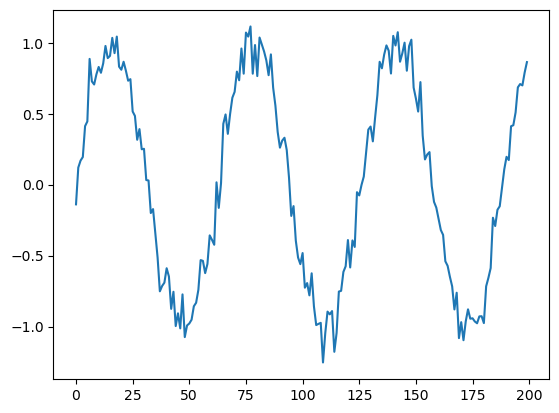

In [3]:
# generate sine wave with 200 points
num_data = 200
series = np.sin(0.1 * np.arange(num_data)) + np.random.randn(num_data) * 0.1

# plot
plt.plot(series)
plt.show()

In [4]:
# Build dataset
T = 10
D = 1 # value of sine-wave
X = []
Y = []

# slide 0 -> 10, 1 -> 11 ... 190 -> 199
for t in range(len(series) - T):
    x = series[t:t + T]
    y = series[t + T] 
    
    X.append(x)
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # make shape N x T x D
Y = np.array(Y)
N = len(X)

print(f"X.shape: {X.shape} | Y.shape: {Y.shape}")
    

X.shape: (190, 10, 1) | Y.shape: (190,)


### 2 Build & Train RNN


In [32]:
# Build RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(5)(i) # default activation is tanh
x = Dense(1)(x) # output layer

model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

# Train the model
r = model.fit(
    X[:-N//2], Y[:-N//2], # train on first half of data
    epochs=2000,
    validation_data=(X[-N//2:], Y[-N//2:]) # validate on 2nd half
)

# Dont want to train-test split & randomly pick samples across time period
# purpose is to enter sequence in order to provide context for purpose of forecasting
# training data should be sequential instead of random

Epoch 1/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.7131 - val_loss: 0.7331
Epoch 2/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.6952 - val_loss: 0.7165
Epoch 3/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.6787 - val_loss: 0.7004
Epoch 4/2000
3/3 [==============================] - 0s 5ms/step - loss: 0.6619 - val_loss: 0.6843
Epoch 5/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.6461 - val_loss: 0.6685
Epoch 6/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.6300 - val_loss: 0.6529
Epoch 7/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.6148 - val_loss: 0.6376
Epoch 8/2000
3/3 [==============================] - 0s 6ms/step - loss: 0.5991 - val_loss: 0.6226
Epoch 9/2000
3/3 [==============================] - 0s 5ms/step - loss: 0.5846 - val_loss: 0.6078
Epoch 10/2000
3/3 [==============================] - 0s 5ms/step - loss: 0.5698 - val_loss: 0.5932
Epoch 11/2000
3/3 

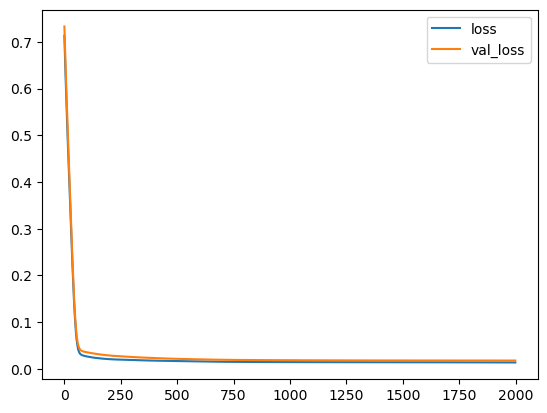

In [33]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

### 3 Perform forecasting using trained RNN

- watch for input shape


In [34]:
validation_target = Y[-N//2:] # 2nd half of data as validation
validation_predictions = []

last_x = X[-N//2] # 1D array of length T (10) i.e 190 - 199

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0, 0] # make last_x into 1 x T x 1
    
    validation_predictions.append(p)
    
    # shift last_x leftwards and append prediction to last
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 6ms/step


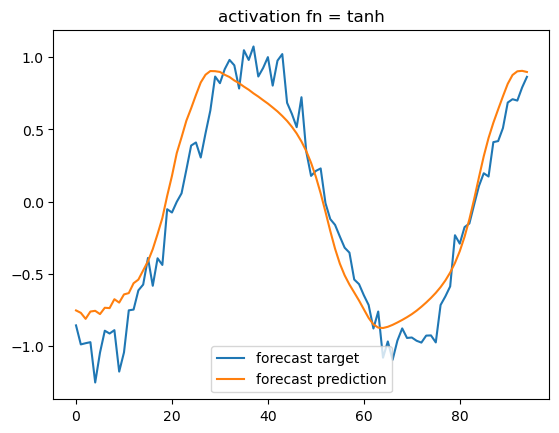

In [35]:
plt.title("activation fn = tanh")
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### No Activation


In [52]:
# Build RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation=None)(i) # default activation is tanh
x = Dense(1)(x) # output layer

model2 = Model(i, x)
model2.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
)

# Train the model
r = model2.fit(
    X[:-N//2], Y[:-N//2], # train on first half of data
    epochs=1000,
    validation_data=(X[-N//2:], Y[-N//2:]) # validate on 2nd half
)

# Dont want to train-test split & randomly pick samples across time period
# purpose is to enter sequence in order to provide context for purpose of forecasting
# training data should be sequential instead of random

Epoch 1/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.2483 - val_loss: 0.1641
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.1581 - val_loss: 0.1178
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.1080 - val_loss: 0.0735
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0676 - val_loss: 0.0475
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0462 - val_loss: 0.0336
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0346 - val_loss: 0.0302
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0331 - val_loss: 0.0313
Epoch 8/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.0300
Epoch 9/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0316 - val_loss: 0.0261
Epoch 10/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0268 - val_loss: 0.0245
Epoch 11/1000
3/3 

In [53]:
validation_predictions2 = []

last_x = X[-N//2] # 1D array of length T (10) i.e 190 - 199

while len(validation_predictions2) < len(validation_target):
    p = model2.predict(last_x.reshape(1, -1, 1))[0, 0] # make last_x into 1 x T x 1
    
    validation_predictions2.append(p)
    
    # shift last_x leftwards and append prediction to last
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 7ms/step


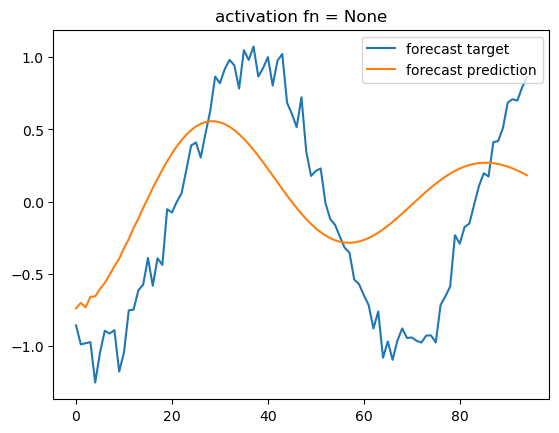

In [55]:
plt.title("activation fn = None")
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions2, label='forecast prediction')
plt.legend()

### ReLU activation


In [66]:
# Build RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation='relu')(i) # default activation is tanh
x = Dense(1)(x) # output layer

model3 = Model(i, x)
model3.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
)

# Train the model
r = model3.fit(
    X[:-N//2], Y[:-N//2], # train on first half of data
    epochs=1000,
    validation_data=(X[-N//2:], Y[-N//2:]) # validate on 2nd half
)

# Dont want to train-test split & randomly pick samples across time period
# purpose is to enter sequence in order to provide context for purpose of forecasting
# training data should be sequential instead of random

Epoch 1/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.2645 - val_loss: 0.3547
Epoch 2/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.2232 - val_loss: 0.3165
Epoch 3/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.1979 - val_loss: 0.2738
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1646 - val_loss: 0.2388
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1457 - val_loss: 0.2155
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1346 - val_loss: 0.1942
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1175 - val_loss: 0.1775
Epoch 8/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.1040 - val_loss: 0.1621
Epoch 9/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0938 - val_loss: 0.1454
Epoch 10/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.0846 - val_loss: 0.1282
Epoch 11/1000
3/3 

In [67]:
validation_predictions3 = []

last_x = X[-N//2] # 1D array of length T (10) i.e 190 - 199

while len(validation_predictions3) < len(validation_target):
    p = model3.predict(last_x.reshape(1, -1, 1))[0, 0] # make last_x into 1 x T x 1
    
    validation_predictions3.append(p)
    
    # shift last_x leftwards and append prediction to last
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 7ms/step


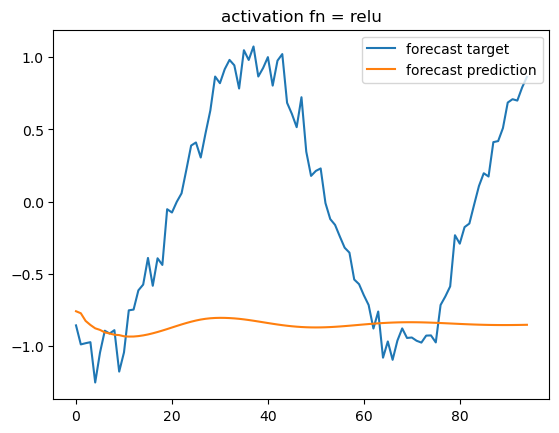

In [68]:
plt.title("activation fn = relu")
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions3, label='forecast prediction')
plt.legend()

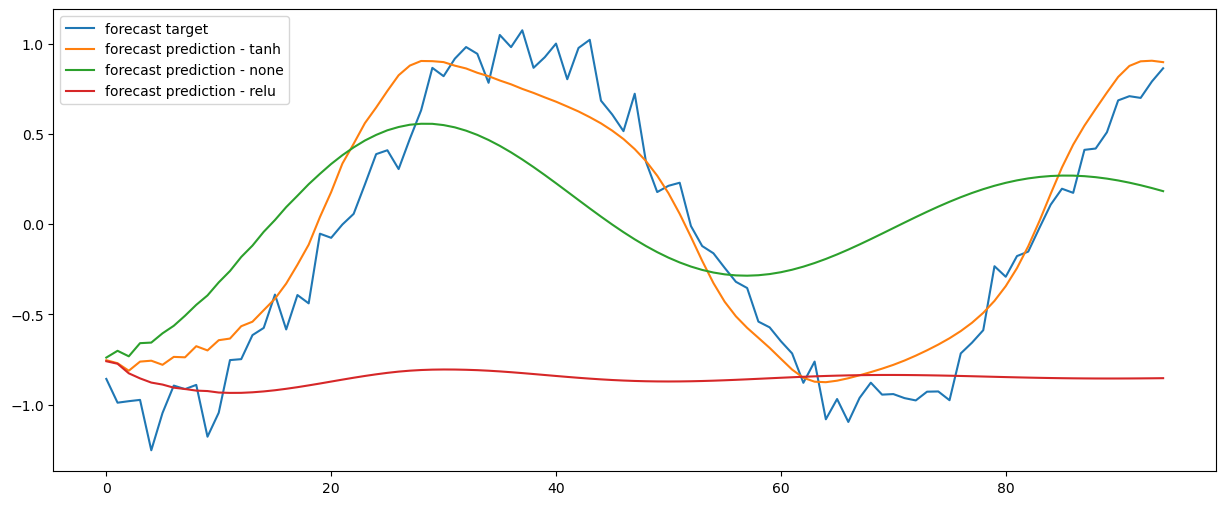

In [69]:
plt.figure(figsize=(15, 6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction - tanh')
plt.plot(validation_predictions2, label='forecast prediction - none')
plt.plot(validation_predictions3, label='forecast prediction - relu')
plt.legend()